# Import and Initialize

In [1]:
import tensorflow as tf

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image

%matplotlib inline 

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


In [3]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
GCS_PATH

'gs://kds-4e8f41e870cec9ae029b5df6b68610ba83e90d41a57a45903da782ed'

# Import Data

In [4]:
IMAGE_FEATURE_DESCRIPTION = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.string)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, IMAGE_FEATURE_DESCRIPTION)

def load_dataset(file_list):
    raw_images = [tf.data.TFRecordDataset(x) for x in file_list]
    return raw_image_dataset

## Monet Files

In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

2022-11-07 00:22:43.141139: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Monet TFRecord Files: 5


In [6]:
raw_monet_images = [tf.data.TFRecordDataset(x) for x in MONET_FILENAMES]
raw_monet_image_dataset = raw_monet_images[0]
type(raw_monet_image_dataset), raw_monet_image_dataset

2022-11-07 00:22:43.422072: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(tensorflow.python.data.ops.readers.TFRecordDatasetV2,
 <TFRecordDatasetV2 shapes: (), types: tf.string>)

2022-11-07 00:22:43.612157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


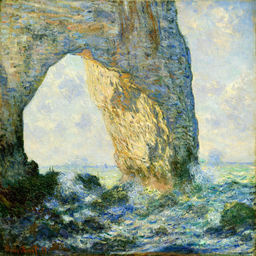

In [7]:
parsed_monet_image_dataset = raw_monet_image_dataset.map(_parse_image_function)

monet_image = next(iter(parsed_monet_image_dataset))['image'].numpy()
display(Image(data=monet_image))

## Base Pictures

In [8]:
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Photo TFRecord Files: 20


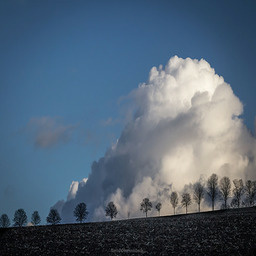

In [9]:
raw_base_images = [tf.data.TFRecordDataset(x) for x in PHOTO_FILENAMES]
raw_base_image_dataset = raw_base_images[0]

parsed_base_image_dataset = raw_base_image_dataset.map(_parse_image_function)

base_image = next(iter(parsed_base_image_dataset))['image'].numpy()
display(Image(data=base_image))

# Image Preprocessing

## Raw Images to Numpy Arrays

In [10]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    example = _parse_image_function(example)
    image = decode_image(example['image'])
    return image

(256, 256, 3)


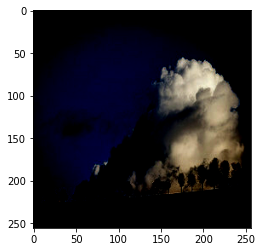

In [11]:
n_arr = read_tfrecord(next(iter(raw_base_image_dataset)))
print(n_arr.shape)

# plt.figure(figsize = (10,10))
plt.imshow(n_arr)

## Building Generator

- Using a [UNET archietecture](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5) because, we don't just want to simply classify the image as monet-or-not but rather convert EVERY pixel to monet-style

In [12]:
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Conv2DTranspose, Input, MaxPooling2D, concatenate

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

In [13]:
def layer(input_layer, filters, kernel_size=(4,4),activation="relu",
          stride=1, padding='same',name=None):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    kernel_initializer=tf.random_normal_initializer(0., 0.02)
    filters = min(filters, 512)
    
    _ = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False, name=name)(input_layer)
    _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
    name = name+'.2' if name else name
    _ = Conv2D(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False, name=name)(_)
    _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
 
    _ = Dropout(0.25)(_)
    
    return _



# def upsample(input_layer, filters, kernel_size=(4,4),
#                activation="relu", stride=2, padding='same'):
#     gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
#     kernel_initializer=tf.random_normal_initializer(0., 0.02)
#     filters = min(filters, 512)
    
#     _ = Conv2DTranspose(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False)(input_layer)
#     _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
#     _ = Conv2DTranspose(filters, kernel_size=kernel_size, activation=activation, padding=padding, strides=stride, kernel_initializer=kernel_initializer, use_bias=False)(_)
#     _ = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(_)
#     _ = Dropout(0.25)(_)
    
#     return _

In [14]:
def create_model(img_shape, name):
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    kernel_initializer=tf.random_normal_initializer(0., 0.02)
    
    # Downsample
    inp = Input(shape=img_shape)
    down0 = layer(inp,64,name='down0')
    _ = MaxPooling2D((2,2))(down0)
    down1 = layer(_,128,name='down1')
    _ = MaxPooling2D((2,2))(down1)
    down2 = layer(_,256,name='down2')
    _ = MaxPooling2D((2,2))(down2)
    down3 = layer(_,512,name='down3')
    _ = MaxPooling2D((2,2))(down3)
    down4 = layer(_,512,name='down4')
    _ = MaxPooling2D((2,2))(down4)
    
    mid = Conv2D(1024, kernel_size=(4,4), activation="relu", padding="same", strides=1, kernel_initializer=kernel_initializer, use_bias=False, name='mid')(_)
    
    # Upsample
    up4 = Conv2DTranspose(512, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(mid) 
    up4 = concatenate([up4, down4])
    up4 = Dropout(0.5)(up4)
    up4 = layer(up4,512,name='up4')
    
    up3 = Conv2DTranspose(512, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up4) 
    up3 = Dropout(0.5)(up3)
    up3 = concatenate([up3, down3])
    up3 = layer(up3,512,name='up3')
    
    up2 = Conv2DTranspose(256, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up3) 
    up2 = Dropout(0.5)(up2)
    up2 = concatenate([up2, down2])
    up2 = layer(up2,256,name='up2')
    
    up1 = Conv2DTranspose(128, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up2) 
    up1 = Dropout(0.5)(up1)
    up1 = concatenate([up1, down1])
    up1 = layer(up1,128,name='up1')
    
    up0 = Conv2DTranspose(64, kernel_size=(4,4), activation="relu", padding="same", strides=2, kernel_initializer=kernel_initializer, use_bias=False)(up1) 
    up0 = Dropout(0.5)(up0)
    up0 = concatenate([up0, down0])
    up0 = layer(up0,64,name='up0')
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(up0)
    
    
    model = Model(inp,output_layer,name=name) 
    
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),loss='mean_squared_error')
    
    return model

generator_mod = create_model(n_arr.shape, name = 'Generator_UNET')

generator_mod.summary()

Model: "Generator_UNET"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
down0 (Conv2D)                  (None, 256, 256, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         down0[0][0]                      
__________________________________________________________________________________________________
down0.2 (Conv2D)                (None, 256, 256, 64) 65536       instance_normalization[0][0]     
_____________________________________________________________________________________